In [52]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import time
import random
from functools import reduce
from chart_studio.plotly import iplot as py
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import modules.Pricing

In [57]:
def rolling_window_calc(df_input, win_size= 6, min_periods=1, verbose= False, plotting=False):
    
    """
    win_size :: number of months to run the rolling average
    min_periods :: 
    
    """
    start = time.time()
    print('running rolling_window_calc..')
    
    cols = df_input.columns.tolist()
    df = pd.DataFrame()
    df_output = pd.DataFrame()
    
    if verbose: print('processing ' + str(df_input.shape[1]) + ' columns.'); print('col number: '); count = 0;
    for col in cols:
        count += 1
        if verbose and count % 500 == 0: print('col ' + str(count) + ' col_name: ' + str(col))
        
        # Normalize the data    
        A = np.nanmin(df_input[col], axis=0)
        B = np.nanmax(df_input[col], axis=0)-np.nanmin(df_input[col], axis=0)
        y = (df_input[col] - A) / B if B > 0 else df_input[col]        
        df['data'] = y
        df['mean'] = y.rolling(win_size, min_periods).mean()
        # df['std'] = y.rolling(win_size, min_periods=1).std()
        # df['median'] = y.rolling(win_size, min_periods=1).median()
        
        # De-Normalize the data
        df_output[col] = A + (df['mean'] * B) if B > 0 else df['mean']
        
        if plotting:
            x = np.arange(len(y))
            plt.plot(x,df['data'], 'lightgray', label='data'); 
            plt.plot(x,df['mean'], 'green', label='rolling mean');
            #plt.plot(x,df['median'], 'red', label='rolling median');
            #plt.plot(x,df['std'], 'lightblue', label='rolling std');

    if verbose:
        print('Input DataFrame:')
        print('- shape: ', df_input.shape)
        print('- Null Counts: ', df_input.isnull().sum().sum())
        print('Output DataFrame:')
        print('- shape: ', df_output.shape)
        print('- Null Counts: ', df_output.isnull().sum().sum())

    end = time.time()
    print('time: ', "{0:.2f}".format(end - start))
    
    return df_output

def visualize_rolling_win(df_before, df_after, n_samples= 8, random_state= 100):
    random.seed(random_state)
    n_samples = n_samples
    plt.figure(figsize = (20, n_samples*3))
    count = 1
    while count < 2 * n_samples:
        col = random.choice(df_before.columns)
        if df_before[col].isnull().sum() == 0:
            x = np.arange(len(df_before[col]))
            plt.subplot(n_samples,4,count)
            plt.plot(x,df_before[col], 'lightgray', label='imputed data');
            plt.plot(x,df_after[col], 'blue', label='despiked data');
            plt.legend();
            count += 1

def savgol_filter_smoothing(df_input, sg_window_length, sg_polyorder, sg_mode='nearest', verbose=False):
    """
    ip_method :: ‘linear’: Ignore the index and treat the values as equally spaced.
    ip_limit :: Maximum number of consecutive NaNs to fill. Must be greater than 0.
    """ 
    start = time.time()
    print('running savgol_filter_smoothing..')
    
    cols = df_input.columns.tolist()
    df_output = df_input.copy(deep=True)
    
    for col in cols:
        
        y_input = np.array(df_output[col])
        y_smooth = savgol_filter(y_input, window_length= sg_window_length, polyorder= sg_polyorder, mode= sg_mode)
        
        # Make sure smoothing process doesn't add more missing values: if it does, then overwrite the NaN from input data
        if np.count_nonzero(~np.isnan(y_input)) > np.count_nonzero(~np.isnan(y_smooth)):
            #print(np.count_nonzero(np.isnan(y_input)), np.count_nonzero(np.isnan(y_smooth)))
            not_null_y = pd.Series(list(map(int, ~np.isnan(y_input))))
            null_ysmooth = pd.Series(list(map(int, np.isnan(y_smooth))))
            mask_list = not_null_y * null_ysmooth
            y_add = mask_list * y_input
            y_smooth_filled = np.nan_to_num(y_smooth)
            #print(y_smooth)
            y_smooth = np.array(y_smooth_filled + y_add)
            #print(y_smooth)
            #break
            #print(np.count_nonzero(np.isnan(y_input)), np.count_nonzero(np.isnan(y_smooth)),'\n')
        
        df_output[col] = y_smooth
        #print(df_output[col].isnull().sum())
    
    # print results
    if verbose:
        print('Input DataFrame:')
        print('- shape: ', df_input.shape)
        print('- Null Counts: ', df_input.isnull().sum().sum())        
        print('Output DataFrame:')
        print('- shape: ', df_output.shape)
        print('- Null Counts: ', df_output.isnull().sum().sum())   
    
    end = time.time()
    print('time: ',"{0:.2f}".format(end - start))
    
    return df_output

running rolling_window_calc..
processing 1 columns.
col number: 
Input DataFrame:
- shape:  (21, 1)
- Null Counts:  0
Output DataFrame:
- shape:  (21, 1)
- Null Counts:  0
time:  0.01
running savgol_filter_smoothing..
time:  0.00


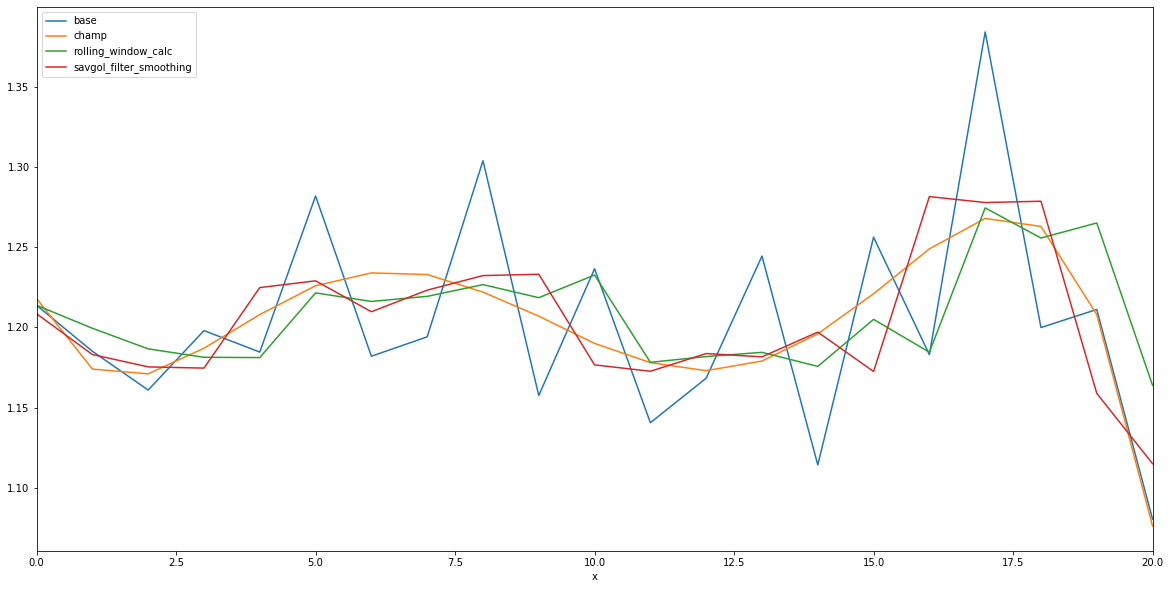

In [78]:
# ivBidMarket = [1.1833, 1.1568, 1.1344, 1.1734, 1.1615, 1.2603, 1.162, 1.1767, 1.2855, 1.1403, 1.22, 1.125, 1.1531, 1.23, 1.1009, 1.2429, 1.1704, 1.3713, 1.188, 1.2026, 1.07]
ivBidMarket = [1.2138, 1.1851, 1.1609, 1.198, 1.1846, 1.282, 1.182, 1.1941, 1.304, 1.1575, 1.2366, 1.1405, 1.1683, 1.2445, 1.1142, 1.2563, 1.183, 1.3844, 1.1999, 1.2112, 1.0803]
ivBidMarketFit = [1.218, 1.174, 1.171, 1.187, 1.208, 1.226, 1.234, 1.233, 1.222, 1.207, 1.19, 1.178, 1.173, 1.179, 1.196, 1.221, 1.249, 1.268, 1.263, 1.208, 1.076]
ivBidMarketdf = pd.DataFrame(ivBidMarket)

ivBidMarketdf[1] = rolling_window_calc(ivBidMarketdf, win_size= 3, min_periods=1, verbose= True, plotting=False)

in_window_length = 5
in_polyorder = 3
in_mode = 'nearest'
# ivBidMarketdf[2] = savgol_filter_smoothing(ivBidMarketdf[0], window_length= sg_window_length, polyorder= sg_polyorder, mode= sg_mode)
ivBidMarketdf[2] = savgol_filter_smoothing(pd.DataFrame(ivBidMarketdf[0]), sg_window_length= in_window_length, sg_polyorder= in_polyorder)

ivBidMarketdf['x'] = ivBidMarketdf.reset_index()['index']
ivBidMarketdf['champ'] = ivBidMarketFit

df = pd.DataFrame({
   'base': ivBidMarketdf[0],
   'champ': ivBidMarketdf['champ'],
   'rolling_window_calc': ivBidMarketdf[1],
   'savgol_filter_smoothing': ivBidMarketdf[2]
   }, index=ivBidMarketdf["x"])
lines = df.plot.line(figsize=(20,10))

# ivBidMarketdf.columns
# visualize_rolling_win(ivBidMarketdf,ivBidMarketdf,n_samples= 2, random_state= 100)

# ivBidMarketdf[0].plot.line()

In [110]:

# ivBidMarketdf[1].index
BidIVFitSavgol = savgol_filter_smoothing(pd.DataFrame(ivBidMarketdf[0]), sg_window_length= in_window_length, sg_polyorder= in_polyorder)
BidIVFitSavgol[0].index

BidIVFitSavgolSeries = pd.Series(BidIVFitSavgol[0].values, index=BidIVFitSavgol[0].index)
# BidIVFitSavgolSeries

list(BidIVFitSavgol[0].values)

running savgol_filter_smoothing..
time:  0.00


[1.2084942857142857,
 1.1830771428571425,
 1.1753514285714282,
 1.1745914285714285,
 1.224842857142857,
 1.2290542857142854,
 1.2097542857142853,
 1.2232342857142855,
 1.232325714285714,
 1.2331685714285712,
 1.1766085714285712,
 1.172608571428571,
 1.1836771428571424,
 1.181602857142857,
 1.1970599999999996,
 1.1724799999999997,
 1.2816314285714283,
 1.2779171428571428,
 1.2787314285714284,
 1.15882,
 1.1149285714285713]

In [96]:
def filterTheDict(dictObj, callback):
    newDict = dict()
    # Iterate over all the items in dictionary
    for (key, value) in dictObj.items():
        # Check if item satisfies the given condition then add to new dict
        if callback((key, value)):
            newDict[key] = value
    return newDict

dictOfNames = {
   7 : 'sam',
   8: 'john',
   9: 'mathew',
   10: 'riti',
   11 : 'aadi',
   12 : 'sachin'
}

print(dictOfNames.keys())
for strike in dictOfNames.keys():
    print("-----")
    print(strike)

# newDict = filterTheDict(dictOfNames, lambda elem: elem[0] == 6)


print(newDict)


dict_keys([7, 8, 9, 10, 11, 12])
-----
7
-----
8
-----
9
-----
10
-----
11
-----
12
{}


In [97]:
# visualize_rolling_win(ivBidMarketdf[0], ivBidMarketdf[1], n_samples= 8, random_state= 100)
# print(ivBidMarketdf[0])

# fig_impact_ts = go.Figure()
# fig_impact_ts.add_trace(go.Scatter(
#                             x=ivBidMarketdf['x'],
#                             y=ivBidMarketdf[0],
#                             mode='lines+markers',
#                             line=dict(width=1),
#                             marker=dict(
#                                 size=5,
#                                 colorscale='Viridis',
#                                 showscale=False
#                             ),
#                             name='before'))

# fig_impact_ts.add_trace(go.Scatter(
#                             x=ivBidMarketdf['x'],
#                             y=ivBidMarketdf[0],
#                             mode='lines+markers',
#                             line=dict(width=1),
#                             marker=dict(
#                                 size=5,
#                                 colorscale='Viridis',
#                                 showscale=False
#                             ),

#                             name='after'))


# fig_impact_ts.show()

fig = px.line(ivBidMarketdf, x="x", y=0)
fig.show()

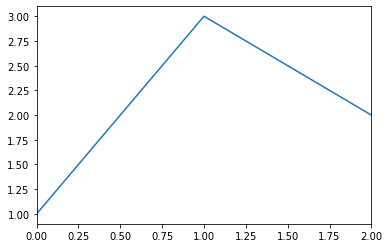